<a href="https://colab.research.google.com/github/DerekZ66/ALY6110/blob/main/ALY6110_Lab2_Yude.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# innstall java
!apt-get install openjdk-8-jdk-headless -qq > /dev/null

# install spark (change the version number if needed)
!wget -q https://archive.apache.org/dist/spark/spark-3.0.0/spark-3.0.0-bin-hadoop3.2.tgz

# unzip the spark file to the current folder
!tar xf spark-3.0.0-bin-hadoop3.2.tgz

# set your spark folder to your system path environment.
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.0.0-bin-hadoop3.2"


# install findspark using pip
!pip install -q findspark

In [3]:
import findspark
findspark.init()
from pyspark.sql import SparkSession
spark = SparkSession.builder.master("local[*]").getOrCreate()

In [4]:
from pyspark.ml.feature import VectorAssembler, StandardScaler, PCA
from pyspark.ml.regression import LinearRegression
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


In [5]:
from google.colab import files
files.upload()

Saving BostonHousing.csv to BostonHousing.csv


{'BostonHousing.csv': b'"crim","zn","indus","chas","nox","rm","age","dis","rad","tax","ptratio","b","lstat","medv"\n0.00632,18,2.31,"0",0.538,6.575,65.2,4.09,1,296,15.3,396.9,4.98,24\n0.02731,0,7.07,"0",0.469,6.421,78.9,4.9671,2,242,17.8,396.9,9.14,21.6\n0.02729,0,7.07,"0",0.469,7.185,61.1,4.9671,2,242,17.8,392.83,4.03,34.7\n0.03237,0,2.18,"0",0.458,6.998,45.8,6.0622,3,222,18.7,394.63,2.94,33.4\n0.06905,0,2.18,"0",0.458,7.147,54.2,6.0622,3,222,18.7,396.9,5.33,36.2\n0.02985,0,2.18,"0",0.458,6.43,58.7,6.0622,3,222,18.7,394.12,5.21,28.7\n0.08829,12.5,7.87,"0",0.524,6.012,66.6,5.5605,5,311,15.2,395.6,12.43,22.9\n0.14455,12.5,7.87,"0",0.524,6.172,96.1,5.9505,5,311,15.2,396.9,19.15,27.1\n0.21124,12.5,7.87,"0",0.524,5.631,100,6.0821,5,311,15.2,386.63,29.93,16.5\n0.17004,12.5,7.87,"0",0.524,6.004,85.9,6.5921,5,311,15.2,386.71,17.1,18.9\n0.22489,12.5,7.87,"0",0.524,6.377,94.3,6.3467,5,311,15.2,392.52,20.45,15\n0.11747,12.5,7.87,"0",0.524,6.009,82.9,6.2267,5,311,15.2,396.9,13.27,18.9\n0.09378,12

In [6]:
# read data set
df = spark.read.csv('BostonHousing.csv',inferSchema=True, header=True)
df.printSchema()

root
 |-- crim: double (nullable = true)
 |-- zn: double (nullable = true)
 |-- indus: double (nullable = true)
 |-- chas: integer (nullable = true)
 |-- nox: double (nullable = true)
 |-- rm: double (nullable = true)
 |-- age: double (nullable = true)
 |-- dis: double (nullable = true)
 |-- rad: integer (nullable = true)
 |-- tax: integer (nullable = true)
 |-- ptratio: double (nullable = true)
 |-- b: double (nullable = true)
 |-- lstat: double (nullable = true)
 |-- medv: double (nullable = true)



In [9]:
# Combine features to a single vector columns using VectorAssembler (all columns other than target column 'medv')
only_features = [col for col in df.columns if col != 'medv']
vec_assembler = VectorAssembler(inputCols=only_features, outputCol="features")
feat_df = vec_assembler.transform(df).select('features')
feat_df.show(6)

+--------------------+
|            features|
+--------------------+
|[0.00632,18.0,2.3...|
|[0.02731,0.0,7.07...|
|[0.02729,0.0,7.07...|
|[0.03237,0.0,2.18...|
|[0.06905,0.0,2.18...|
|[0.02985,0.0,2.18...|
+--------------------+
only showing top 6 rows



In [11]:
# Standardize features for principal component analysis
scaler = StandardScaler(inputCol="features", outputCol="scaled_features", withMean=True, withStd=True).fit(feat_df)

df_scaled = scaler.transform(feat_df)
df_scaled.show(8)

+--------------------+--------------------+
|            features|     scaled_features|
+--------------------+--------------------+
|[0.00632,18.0,2.3...|[-0.4193669292132...|
|[0.02731,0.0,7.07...|[-0.4169266699640...|
|[0.02729,0.0,7.07...|[-0.4169289951277...|
|[0.03237,0.0,2.18...|[-0.4163384035610...|
|[0.06905,0.0,2.18...|[-0.4120740534296...|
|[0.02985,0.0,2.18...|[-0.4166313741807...|
|[0.08829,12.5,7.8...|[-0.4098372459997...|
|[0.14455,12.5,7.8...|[-0.4032965606564...|
+--------------------+--------------------+
only showing top 8 rows



In [13]:
# Train model for two principal component analysis

pca = PCA(k=2, inputCol="scaled_features", outputCol="pca_features").fit(df_scaled)

df_pca = pca.transform(df_scaled)
print('Explained variance Ratio', pca.explainedVariance.toArray())
df_pca.show(8)

Explained variance Ratio [0.47129606 0.11025193]
+--------------------+--------------------+--------------------+
|            features|     scaled_features|        pca_features|
+--------------------+--------------------+--------------------+
|[0.00632,18.0,2.3...|[-0.4193669292132...|[2.09622303023858...|
|[0.02731,0.0,7.07...|[-0.4169266699640...|[1.45581098944742...|
|[0.02729,0.0,7.07...|[-0.4169289951277...|[2.07254655194818...|
|[0.03237,0.0,2.18...|[-0.4163384035610...|[2.60892175886434...|
|[0.06905,0.0,2.18...|[-0.4120740534296...|[2.45575477193107...|
|[0.02985,0.0,2.18...|[-0.4166313741807...|[2.21266184319277...|
|[0.08829,12.5,7.8...|[-0.4098372459997...|[1.35753765586535...|
|[0.14455,12.5,7.8...|[-0.4032965606564...|[0.84121214171331...|
+--------------------+--------------------+--------------------+
only showing top 8 rows



In [20]:
# Collect distributed data in numpy array and then convert to pandas dataframe

X_pca = df_pca.rdd.map(lambda row: row.pca_features).collect()
X_pca = np.array(X_pca)
pandas_df = pd.DataFrame(X_pca, columns=["PCA1", "PCA2"])
pandas_df.head()

,PCA1,PCA2
0,2.096223,0.772348
1,1.455811,0.591400
2,2.072547,0.599047
3,2.608922,-0.006864
4,2.455755,0.097615


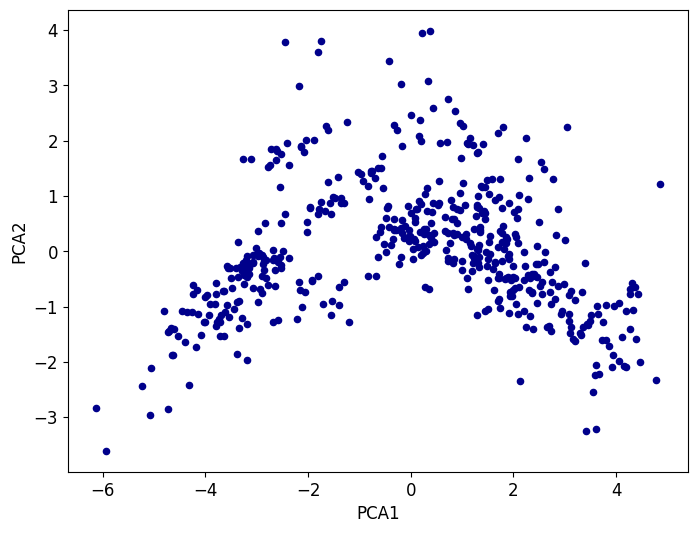

In [23]:
# Plot two principal components
plt.rcParams['figure.figsize'] = 8,6
plt.rcParams['font.size'] = 12
ax1 = pandas_df.plot.scatter(x='PCA1', y='PCA2', c='Darkblue')

In [26]:
# Vectorize features and target together for model development

output = vec_assembler.transform(df)

finalized_data = output.select("features","medv")
finalized_data.show()

+--------------------+----+
|            features|medv|
+--------------------+----+
|[0.00632,18.0,2.3...|24.0|
|[0.02731,0.0,7.07...|21.6|
|[0.02729,0.0,7.07...|34.7|
|[0.03237,0.0,2.18...|33.4|
|[0.06905,0.0,2.18...|36.2|
|[0.02985,0.0,2.18...|28.7|
|[0.08829,12.5,7.8...|22.9|
|[0.14455,12.5,7.8...|27.1|
|[0.21124,12.5,7.8...|16.5|
|[0.17004,12.5,7.8...|18.9|
|[0.22489,12.5,7.8...|15.0|
|[0.11747,12.5,7.8...|18.9|
|[0.09378,12.5,7.8...|21.7|
|[0.62976,0.0,8.14...|20.4|
|[0.63796,0.0,8.14...|18.2|
|[0.62739,0.0,8.14...|19.9|
|[1.05393,0.0,8.14...|23.1|
|[0.7842,0.0,8.14,...|17.5|
|[0.80271,0.0,8.14...|20.2|
|[0.7258,0.0,8.14,...|18.2|
+--------------------+----+
only showing top 20 rows



In [29]:
# Split dataset into training and testing dataset
np.random.seed(123)
train_data, test_data = finalized_data.randomSplit([0.8,0.2])


In [30]:
# Fit model for linear regression
lr = LinearRegression(featuresCol="features", labelCol="medv")
lr_model = lr.fit(train_data)

In [33]:
# Find out model coefficients and intercept

coefficients = lr_model.coefficients

intercept = lr_model.intercept

print("Coefficients: %a" %coefficients)
print("Intercept: %f" %intercept)


Coefficients: DenseVector([-0.1053, 0.0435, -0.0226, 2.8397, -16.3766, 4.2237, -0.0213, -1.5266, 0.2754, -0.011, -0.8905, 0.0083, -0.4437])
Intercept: 33.059691


In [34]:
# Evaluate model for test dataset
pred = lr_model.evaluate(test_data)
pred.predictions.show()

+--------------------+----+------------------+
|            features|medv|        prediction|
+--------------------+----+------------------+
|[0.01096,55.0,2.2...|22.0| 27.42951627177085|
|[0.01381,80.0,0.4...|50.0|41.005209859893014|
|[0.01709,90.0,2.0...|30.1|24.726464059740756|
|[0.01778,95.0,1.4...|32.9|31.201366281143535|
|[0.01965,80.0,1.7...|20.1|20.478261379711995|
|[0.02177,82.5,2.0...|42.3| 37.57993978228866|
|[0.02763,75.0,2.9...|30.8|31.517517392149013|
|[0.03578,20.0,3.3...|45.4| 38.36605938308922|
|[0.03961,0.0,5.19...|21.1|20.797884737659352|
|[0.04011,80.0,1.5...|33.3| 35.97890271761573|
|[0.04294,28.0,15....|20.6| 26.08432168061464|
|[0.04297,52.5,5.3...|24.8| 27.17339696002483|
|[0.04417,70.0,2.2...|24.8|30.375434462717365|
|[0.04462,25.0,4.8...|23.9| 26.44191799852449|
|[0.04666,80.0,1.5...|30.3| 32.80108519738876|
|[0.04932,33.0,2.1...|28.2|32.337876563018874|
|[0.05023,35.0,6.0...|17.1|20.267233700380736|
|[0.05372,0.0,13.9...|27.1|26.717128640662008|
|[0.05497,0.0

In [42]:
from pyspark.ml.evaluation import RegressionEvaluator

evaluator = RegressionEvaluator(labelCol="medv", predictionCol="prediction", metricName="rmse")
rmse = evaluator.evaluate(pred.predictions)

mae_evaluator = RegressionEvaluator(labelCol="medv", predictionCol="prediction", metricName="mae")
mae = mae_evaluator.evaluate(pred.predictions)

mse_evaluator = RegressionEvaluator(labelCol="medv", predictionCol="prediction", metricName="mse")
mse = mse_evaluator.evaluate(pred.predictions)

r2_evaluator = RegressionEvaluator(labelCol="medv", predictionCol="prediction", metricName="r2")
r2 = r2_evaluator.evaluate(pred.predictions)

# Display the evaluation results
print("Root Mean Squared Error (RMSE):", rmse)
print("Mean Absolute Error (MAE):", mae)
print("Mean Squared Error (MSE):", mse)
print("R-Squared (R\u00b2):", r2)


Root Mean Squared Error (RMSE): 5.02402742041297
Mean Absolute Error (MAE): 3.401476951445041
Mean Squared Error (MSE): 25.240851521061394
R-Squared (R²): 0.7215314390331711


In [43]:
from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml import Pipeline
from pyspark.ml.tuning import ParamGridBuilder
from pyspark.ml.tuning import CrossValidator

In [44]:
regressorRF = RandomForestRegressor(featuresCol= "features", labelCol="medv")
pipeline = Pipeline(stages = [vec_assembler, regressorRF])

In [45]:
pipeline.write().overwrite().save("pipeline")

In [46]:
# Hyperparameter Tuning
pipelineModel = Pipeline.load("pipeline")
paramGrid = ParamGridBuilder().addGrid(regressorRF.numTrees, [100, 500]).build()

In [47]:
eval = RegressionEvaluator(labelCol="medv", predictionCol="predictions", metricName="rmse")

In [49]:
crossval = CrossValidator(estimator=pipelineModel, estimatorParamMaps=paramGrid, evaluator=RegressionEvaluator(labelCol="medv"), numFolds = 5)

In [51]:
train_data, test_data = df.randomSplit([0.8,0.2], seed=123)
cvModel = crossval.fit(train_data)

In [52]:
bestModel = cvModel.bestModel
for x in range(len(bestModel.stages)):
  print(bestModel.stages[x])

VectorAssembler_fe297f703964
RandomForestRegressionModel: uid=RandomForestRegressor_f9e05360722a, numTrees=100, numFeatures=13


In [53]:
pred = cvModel.transform(test_data)
pred.select("medv", "prediction").show()

+----+------------------+
|medv|        prediction|
+----+------------------+
|22.0|24.632279373523435|
|50.0| 43.99273165668068|
|30.1|30.646406430902662|
|32.9| 35.50160131526201|
|24.7| 24.61820815486667|
|34.7|35.792748705080584|
|18.5|20.686153787818466|
|31.2| 27.88434289652582|
|33.4| 35.46506003637237|
|20.6| 21.40128838698165|
|34.9|  36.6741563294856|
|19.4| 22.98963948538977|
|48.5|45.299190779591825|
|24.8|23.454065880980384|
|28.0|26.593607842038555|
|19.4|21.691583601971093|
|22.5|21.469547049740548|
|27.1| 23.97955674459354|
|29.0| 32.95471080448563|
|33.1|29.261045029360403|
+----+------------------+
only showing top 20 rows



In [54]:
eval = RegressionEvaluator(labelCol= "medv")
rmse = eval.evaluate(pred)
mse = eval.evaluate(pred, {eval.metricName: "mse"})
mae = eval.evaluate(pred, {eval.metricName: "mae"})
r2 = eval.evaluate(pred, {eval.metricName: "r2"})

In [57]:
print("Root Mean Squared Error (RMSE): %.3f" %rmse)
print("Mean Absolute Error (MAE): %.3f" %mae)
print("Mean Squared Error (MSE): %.3f" %mse)
print("R-Squared (R\u00b2): %.3f" %r2)

Root Mean Squared Error (RMSE): 3.075
Mean Absolute Error (MAE): 2.368
Mean Squared Error (MSE): 9.456
R-Squared (R²): 0.880


In [58]:
spark.stop()